## HW 2: Feedforward, Gradient Descent, and Backprop

In [383]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.display import SVG
import pandas as pd
%matplotlib inline

#### Problem 1. Feedforward

1. Here is a network with two input units, one hidden layer with three hidden units, and a one unit output layer.

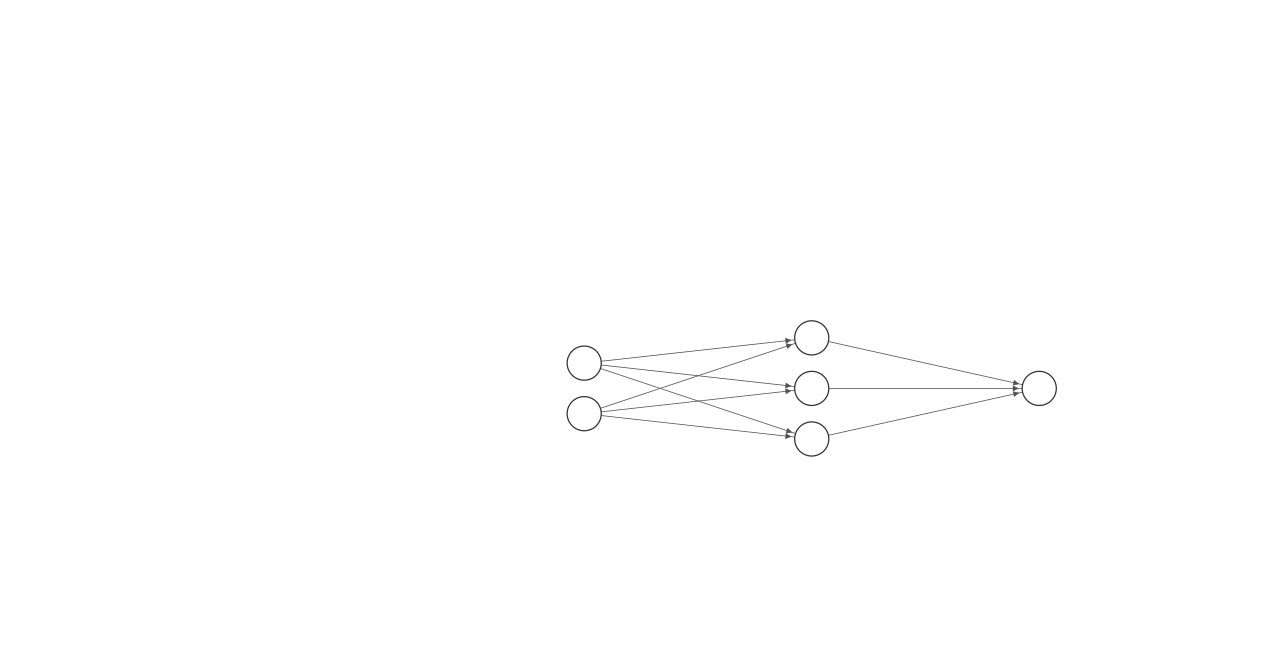

In [11]:
SVG(filename='nn.svg')

2. We write out the mathematical equation for the output of this network below.

In the diagram above, imagine the two input nodes are labeled $x_1$ and $x_2$, the three hidden nodes are $h_1$, $h_2$, and $h_3$, and the output node is $\hat{y}$. The edges from the input layer to the hidden layer are labeled $w_{ij}$ for going from input $x_i$ to hidden node $h_j$, and the edges from the hidden layer to the output layer are $v_j$, from hidden unit $h_j$ to $\hat{y}$. The bias vector for the hidden layer is not shown, nor is the bias constant for the output layer.

Let $h_j = \max(0, a_j)$, where $a_j$ is a weighted sum from the previous layer plus a bias unit. That is,
$$
a_1 = w_{11}x_1 + w_{21}x_2 + b_1 \\
a_2 = w_{12}x_1 + w_{22}x_2 + b_2 \\
a_3 = w_{13}x_1 + w_{23}x_2 + b_3 \\
\Rightarrow a_j = w_{1j}x_1 + w_{2j} + b_j
$$

Similarly,

$$ \hat{y} = g(v_1h_1 + v_2h_2 + v_3h_3 + c), $$
where $g$ is the output function (in this case, for binary classification, $g$ is the sigmoid function). Expanding the above expression to show $\hat{y}$ as a function of all of the variables of the graph, we obtain
$$ \hat{y} = g\big[v_1\max(0, w_{11}x_1 + w_{21}x_2 + b_1) \\ + v_2\max(0, w_{12}x_1 + w_{22}x_2 + b_2) \\ + v_3\max(0, w_{13}x_1 + w_{23}x_2 + b_3) + c\large].$$

We can express this succinctly using matrix notation. If

$$ W = \begin{bmatrix}
w_{11} &w_{12} &w_{13}\\
w_{21} &w_{22} &w_{23}\\
\end{bmatrix}, \hspace{.5cm} \mathbf{x} = \begin{bmatrix} x_1 \\x_2 \end{bmatrix}, \hspace{.5cm} \mathbf{b} = \begin{bmatrix} b_1 \\b_2 \\b_3\end{bmatrix}, \hspace{.5cm} \mathbf{h} = \begin{bmatrix} h_1 \\h_2 \\h_3\end{bmatrix}, \hspace{.5cm} \text{and} \hspace{.5cm} \mathbf{v} = \begin{bmatrix} v_1 \\v_2 \\v_3\end{bmatrix},$$

then
$a_j = W^{T}\mathbf{x} + \mathbf{b}$, $h_j = \max(0, a_j)$, and $\hat{y} = g(\mathbf{v^{T}}\cdot\mathbf{h} + c)$.


In [84]:
sigmoid = lambda x: 1/(1+np.exp(-x))

In [94]:
def ff_nn_ReLu(X, W, v, b, c):
    """ Compute forward pass of network."""
    a = W.T.dot(X) + b
    h = np.maximum(0, a)
    y_hat = sigmoid(v.T.dot(h) + c)
    return y_hat

In [324]:
X_1 = np.array([1, -1], dtype=np.float32)
X_2 = np.array([0, -1], dtype=np.float32)
X_3 = np.array([0, 1], dtype=np.float32)
W = np.array([[1, -1, 0], [0, 0, 0.5]], dtype=np.float32)
print(W.shape)
v = np.array([1, 0, -1], dtype=np.float32)
print(v.shape)
b = np.array([0, 0, 1], dtype=np.float32)
print(b.shape)
c = 1

(2, 3)
(3,)
(3,)


In [97]:
print(ff_nn_ReLu(X_1, W, v, b, c))
print(ff_nn_ReLu(X_2, W, v, b, c))
print(ff_nn_ReLu(X_3, W, v, b, c))

0.8175744761936437
0.6224593312018546
0.3775406687981454


In [98]:
X = np.array([[1, -1], [0, -1], [0,1]], dtype=np.float32)

In [110]:
# Or if X is provided as a single matrix
print(np.apply_along_axis(ff_nn_ReLu, 1, X, W=W, v=v, b=b, c=c))

[0.81757448 0.62245933 0.37754067]


#### Problem 2. Gradient Descent

Problem 1. For the function
$$ f(x,y) = (1-x^3) + 100(y^2-x)^2$$
we compute the partial derivatives as
$$ \frac{\partial f}{\partial x}= -3x^2 - 200(y^2 - x)$$
and 
$$ \frac{\partial f}{\partial y}= 400(y^2 - x).$$

Problem 2. We create a visualization of the contours of $f(x,y)$ below.

In [142]:
def f(x, y):
    return (1 - x**3) + 100 * (y**2 - x)**2

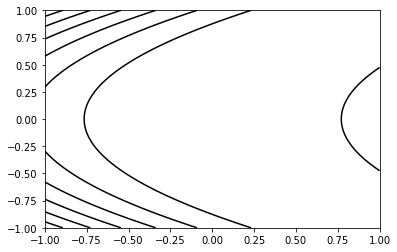

In [215]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
plt.contour(X, Y, Z, colors='black')

3. Gradient Descent algorithm

In [263]:
def grad_f(x, y):
    return -3*x**2 - 200 * (y**2 - x), 400 * y * (y**2 - x)

In [284]:
def grad_descent(x_0, y_0, iters, step_size):
    x = x_0
    y = y_0
    results = [(x, y)]
    for i in range(iters):
        grad_x, grad_y = grad_f(x, y)
        if grad_x < 0:
            dx = step_size
        if grad_y < 0:
            dy = step_size
        if grad_x > 0:
            dx = -step_size
        if grad_y > 0:
            dy = -step_size
        if grad_x == 0:
            dx = 0
        if grad_y == 0:
            dy = 0
        x = x + dx
        y = y + dy
        results.append((x, y))
    #print(results)
    return results

In [285]:
print(grad_descent(-1, 1, 1000, 0.001)[-1])
print(grad_descent(20, 0, 1000, 0.1)[-1])
print(grad_descent(-2, 1, 1000, 0.1)[-1])
print(grad_descent(1, 1, 100, 0.5)[-1])

(8.81239525796218e-16, -8.81239525796218e-16)
(-1.529332216421153e-14, 0)
(6.38378239159465e-16, 1.3877787807814457e-16)
(1.0, 1.5)


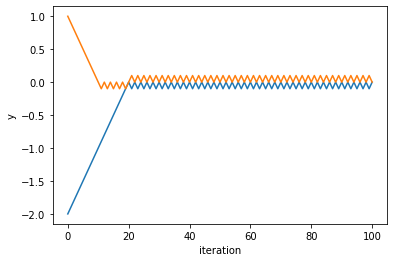

In [305]:
xs = grad_descent(-2, 1, 100, 0.1)
X = [i[0] for i in xs]
Y = [i[1] for i in xs]
plt.plot(X, '-')
plt.xlabel('iteration')
plt.ylabel('x')
plt.plot(Y, '-')
plt.xlabel('iteration')
plt.ylabel('y')
plt.show()

In [306]:
def grad_descent_momentum(x_0, y_0, iters, step_size, initial_velocity=(1,1), alpha=0.01):
    x = x_0
    y = y_0
    v = initial_velocity
    results = [(x, y)]
    for i in range(iters):
        grad_x, grad_y = grad_f(x, y)
        '''
        if grad_x < 0:
            dx = step_size
        if grad_y < 0:
            dy = step_size
        if grad_x > 0:
            dx = -step_size
        if grad_y > 0:
            dy = -step_size
        if grad_x == 0:
            dx = 0
        if grad_y == 0:
            dy = 0
        '''
        v = alpha * v[0] - step_size*grad_x, alpha * v[1] - step_size*grad_y
        x = x + v[0]
        y = y + v[1]
        results.append((x, y))
    #print(results)
    return results

In [322]:
grad_descent_momentum(1, 10, 1000, 0.01, initial_velocity=(0.1,0.1), alpha=0.01)[-1]

(-0.019897969594904884, -0.019897969594901053)

#### Problem 3. Backprop

In [577]:
# propagate forward to save everything

sigmoid = lambda x: 1/(1+np.exp(-x))

derivative_of_sigmoid = lambda x: sigmoid(x) * (1-sigmoid(x))


# everthing but grad_f is private

class ANN:
    
    def __init__(self):
        self.W = np.random.uniform(low=.1, high=.8, size=(2,3))
        self.v = np.random.uniform(low=.1, high=.8, size=(3,1))
        self.b = np.random.uniform(low=.1, high=.8, size=(3,1))
        self.c = np.random.uniform(low=.1, high=.8, size=())
        
        self.a = None
        self.z_layer2 = None
        self.z = None
        #self.grad_loss = None
        self.yhat = None
        self.y = 1
        self._forward_pass(np.random.uniform(low=.1, high=.8, size=(2,1)), self.y)
        
    def grad_of_loss(self):
        return (self.y/self.yhat) + ((1-self.y)/(1-self.yhat))

    def _forward_pass(self, X, y):
        """Compute forward pass of network."""
        self.z_2 = self.W.T.dot(X) + self.b
        self.a = np.maximum(0, self.z_2)
        self.z = self.v.T.dot(self.a) + self.c
        self.yhat = sigmoid(self.z)
        self.y = y
        #self.loss = get_loss()
    
    def grad_f(self, X, return_val='w'):
        
        delta_L = self.grad_of_loss() * derivative_of_sigmoid(self.z)
        #print(delta_L)
        delta_2 = self.v.dot(delta_L) * derivative_of_sigmoid(self.z_2)

        #print(delta_L.shape, delta_2.shape)
        
        if return_val == 'v':
            return delta_L * self.a
        if return_val == 'w':
            return delta_2.dot(X.T)
        if return_val == 'b':
            return delta_2
        if return_val == 'c':
            return delta_L
        
    def get_loss(self):
        return np.asscalar(-self.y * np.log(self.yhat) - (1-self.y) * np.log(1-self.yhat))
    
    def grad_descent(self, X, y, iterations=5, learning_rate=0.001): # X is multiple examples
        loss = []
        
        for i in range(iterations): # epochs
            for example, output in zip(np.vsplit(X, X.shape[0]), np.split(y, y.shape[0])): # 400 examples
                self._forward_pass(example.T, output)
                self.v = self.v - learning_rate * self.grad_f(example.T, 'v')
                self.W = self.W - (learning_rate * self.grad_f(example.T, 'w')).T
                self.b = self.b - learning_rate * self.grad_f(example.T, 'b')
                self.c = self.c - learning_rate * self.grad_f(example.T, 'c')
                loss.append(self.get_loss())
        return loss
    
    def predict(self, X): # compute Y | X
        z_2 = self.W.T.dot(X) + self.b
        a = np.maximum(0, z_2)
        z = self.v.T.dot(a) + self.c
        yhat = sigmoid(z)
        return y_hat
    

    # work in progress
    
    def grad_descent_momentum(self, X, y, iterations=5, learning_rate=0.001,
                              initial_velocity, alpha=0.01): # alpha is momentum parameter
        loss = []
        velocity = initial
        for i in range(iterations): # epochs
            for example, output in zip(np.vsplit(X, X.shape[0]), np.split(y, y.shape[0])): # 400 examples
                self._forward_pass(example.T, output)
                self.v = self.v - learning_rate * self.grad_f(example.T, 'v') 
                self.W = self.W - (learning_rate * self.grad_f(example.T, 'w')).T
                self.b = self.b - learning_rate * self.grad_f(example.T, 'b')
                self.c = self.c - learning_rate * self.grad_f(example.T, 'c')
                loss.append(self.get_loss())
        return loss


In [567]:
network = ANN()
network.grad_f(np.random.uniform(low=.1, high=.8, size=(2,1)), 'w')

array([[0.00469255, 0.00370655],
       [0.00792309, 0.00625829],
       [0.00590132, 0.00466133]])

//anaconda3/envs/anly590/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


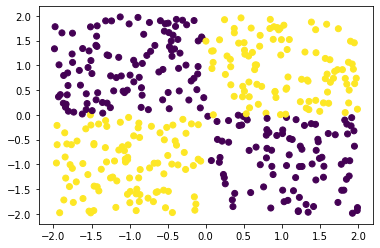

In [568]:
x = np.random.uniform(low=-2, high=2, size=(400,))
y = np.random.uniform(low=-2, high=2, size=(400,))
c = (x < 0) & (y < 0) | (x > 0) & (y > 0)

data = pd.DataFrame({'x': x, 'y': y, 'c' : c})
plt.scatter(data.x, data.y, c=data.c)
data.c[data.c] = 1
data.c[data.c] = 0

In [578]:
# 2 columns x, y not row and column
# epochs not iters
network = ANN()
network.grad_f(np.random.uniform(low=.1, high=.8, size=(2,1)), 'w')
losses = network.grad_descent(X=data[['x', 'y']].to_numpy(), y=data['c'].to_numpy(), iterations=4, learning_rate=0.001)
losses

//anaconda3/envs/anly590/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


[1.6252154657297118,
 2.2515226940563773,
 0.6079806853694638,
 0.39696082474581823,
 0.11662565161158979,
 0.5980095096747254,
 0.8444628762680322,
 0.6088528719570603,
 0.5881403820027893,
 1.1603670806102087,
 1.0126810447692316,
 1.5180756875719466,
 1.4659081312981406,
 0.06789489552098708,
 0.6106056979248308,
 1.5277913071744855,
 1.782612051812249,
 0.1528564199690092,
 0.09625419506225208,
 0.6116598196226338,
 2.21840368419858,
 1.870163645992809,
 1.4839879501399735,
 0.07269802084283937,
 2.189247546767575,
 0.16967827401608565,
 0.13817590033707647,
 0.6135888439652953,
 1.538182227040004,
 1.4740443477569658,
 1.3831311604602716,
 0.49512378348687486,
 1.4816956432988977,
 1.5217007497854562,
 0.6157510997571475,
 1.5295384655471054,
 1.4573604810198848,
 1.101837635848152,
 1.14604798403867,
 1.4774820610322514,
 1.1293367988266374,
 1.915731703715032,
 1.1301349739245543,
 0.07155600925606212,
 1.0203498709559589,
 1.1085727480635228,
 0.619306505321477,
 0.123870569946

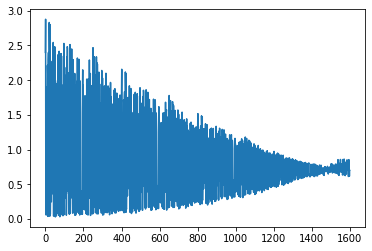

In [574]:
plt.plot(losses)

In [586]:
xx, yy = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = network.predict(np.c_[xx.ravel(), yy.ravel()])
#network.predict(X_vals)

ValueError: shapes (3,2) and (1600,2) not aligned: 2 (dim 1) != 1600 (dim 0)